In [32]:
import os
import json
import argparse
import csv
from pathlib import Path
from subprocess import check_output
import time
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast

'''
Combines all the hyperparameter results into a single csv file by gping through all the output log files.
'''


'\nCombines all the hyperparameter results into a single csv file by gping through all the output log files.\n'

In [33]:
start_trial_index = 0
end_trial_index = 1000
model_type = 'cnnFZ'
output_csv = f'hyperparameter_tuning/{model_type}/results_{model_type}.csv'
list_of_dicts = json.load(open(f'hyperparameter_tuning/{model_type}/list_of_dicts.json', 'r'))
# dict_files = glob.glob(f'hyperparameter_tuning/{model_type}/result*.json')
# out_files = glob.glob(f'hyperparameter_tuning/{model_type}/*.out')
# error_files = glob.glob(f'hyperparameter_tuning/{model_type}/*.err')

In [39]:
# double or single index predictions
result_df = pd.DataFrame(columns=['index','success','accuracy','median','val_loss','test_loss','train_time','incomplete'])
pattern = r"real\s+(\d+)m"
val_pattern = r"val_loss did not improve from (\d+\.\d+)"

for i in range(start_trial_index, end_trial_index):
    result_dicts_loc = glob.glob(f'hyperparameter_tuning/{model_type}/result_{i}_*_{i}.json')
    out_files = glob.glob(f'hyperparameter_tuning/{model_type}/tuner_*_{i}.out')
    error_files = glob.glob(f'hyperparameter_tuning/{model_type}/tuner_*_{i}.err')
    if len(result_dicts_loc) == 0:
        result_df.at[i,'index'] = i
        result_df.at[i,'success'] = False
    else:
        best_median = 0
        best_dict = None
        for dict in result_dicts_loc:
            temp_dict = json.load(open(dict, 'r'))
            if temp_dict['median'][0] > best_median:
                best_dict = temp_dict
                best_median = temp_dict['median'][0]
        result_df.at[i,'index'] = i
        result_df.at[i,'success'] = True
        result_df.at[i,'accuracy'] = best_dict['accuracy']
        result_df.at[i,'median'] = best_dict['median']
        result_df.at[i,'val_loss'] = best_dict['val_loss']
        result_df.at[i,'test_loss'] = best_dict['loss']
    max_time = 0
    for error_file in error_files:
        with open(error_file, 'r') as f:
            content = f.read()
            matches = re.findall(pattern, content)
            if matches:
                if max_time < int(matches[0]):
                    max_time = int(matches[0])
            else:
                if 'DUE TO TIME LIMIT' in content:
                    result_df.at[i,'incomplete'] = True
                    max_time = 540
                else:
                    print(error_file)
                    #raise Exception('No time found')
                    continue
    result_df.at[i,'train_time'] = max_time
    best_val_loss = 10000000
    for output_file in out_files:
        with open(output_file, 'r') as f:
            content = f.read()
            match = re.findall(val_pattern, content)
            if match:
                val_loss = float(match[-1])
                if best_val_loss > val_loss:
                    best_val_loss = val_loss
    result_df.at[i,'val_loss'] = best_val_loss


In [43]:
result_df

,index,success,accuracy,median,val_loss,test_loss,train_time,incomplete
0,0,True,"[0.0, 18.75]","[100.0, 1.6846174001693726]",48.548,25086.4,98,NaN
1,1,False,NaN,NaN,10000000,NaN,0,NaN
2,2,False,NaN,NaN,10000000,NaN,0,NaN
3,3,False,NaN,NaN,10000000,NaN,0,NaN
4,4,False,NaN,NaN,10000000,NaN,0,NaN
...,...,...,...,...,...,...,...,...
995,995,False,NaN,NaN,10000000,NaN,0,NaN
996,996,False,NaN,NaN,10000000,NaN,0,NaN
997,997,False,NaN,NaN,10000000,NaN,0,NaN
998,998,False,NaN,NaN,10000000,NaN,0,NaN


In [44]:
result_df = result_df[result_df['success']]
result_df[["accuracy_f", "accuracy_z"]] = result_df["accuracy"].apply(lambda x: pd.Series([x[0], x[1]]))
result_df[["median_f", "median_z"]] = result_df["median"].apply(lambda x: pd.Series([x[0], x[1]]))

/u/atya/conda-envs/tf-gpu4/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [48]:
result_df.max()

index                    994
success                 True
accuracy       [77.25, 41.5]
median        [100.0, 100.0]
val_loss             53934.1
test_loss              51393
train_time               540
incomplete              True
accuracy_f             77.25
accuracy_z             56.75
median_f                 100
median_z                 100
dtype: object

In [24]:
dicts_df = pd.DataFrame(list_of_dicts)
# merge the two dataframes using the index
result_df = result_df.merge(dicts_df, left_on='index', right_on='index')

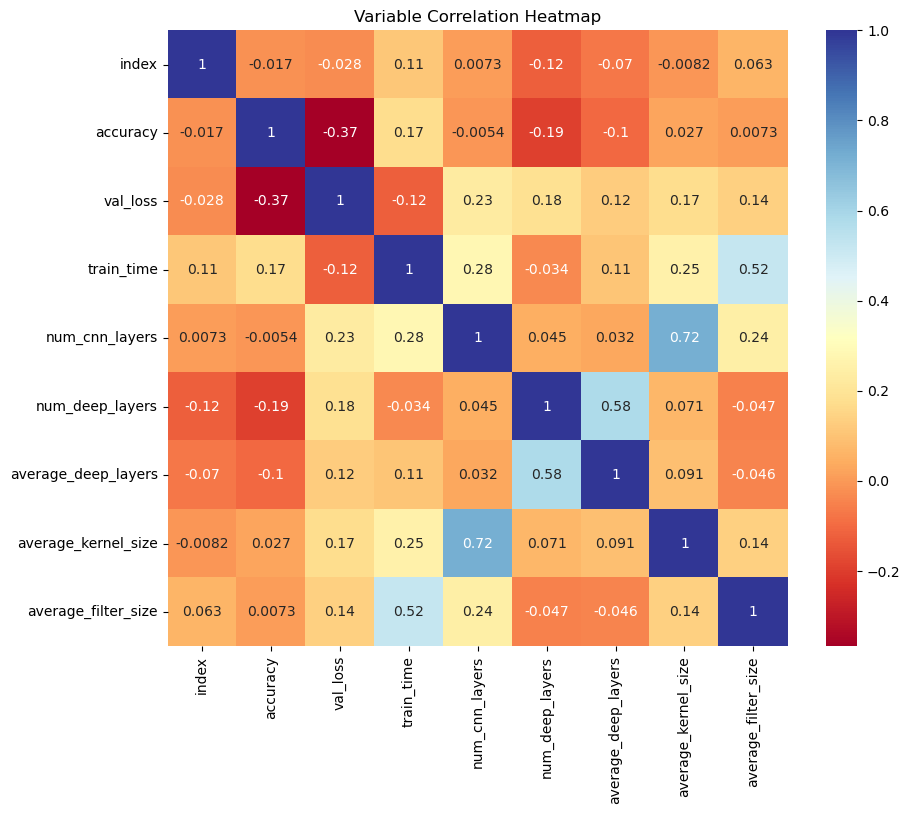

In [27]:
# Assuming you have a DataFrame called 'df' with your data
result_df_temp = result_df[['index', 'accuracy', 'val_loss',
       'train_time', 'num_cnn_layers', 'num_deep_layers',
       'average_deep_layers',
       'average_kernel_size','average_filter_size']]
result_df_nonan = result_df_temp.dropna().astype(float)
correlation_matrix = result_df_nonan.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlBu")
plt.title("Variable Correlation Heatmap")
plt.show()

In [9]:
result_df.columns

Index(['index', 'success', 'accuracy', 'median', 'val_loss', 'test_loss',
       'train_time', 'incomplete', 'num_cnn_layers', 'num_deep_layers',
       'initial_learning_rate', 'decay_rate', 'batch_size', 'deep_layer_size',
       'epochs', 'patience', 'input_shape', 'padding', 'dilation',
       'conv1d_filters', 'conv1d_kernel_size', 'batch_normalization',
       'dilation_rate_size'],
      dtype='object')

In [26]:
result_df['average_kernel_size'] = result_df['conv1d_kernel_size'].apply(lambda x: np.mean(ast.literal_eval(x)))
result_df['average_filter_size'] = result_df['conv1d_filters'].apply(lambda x: np.mean(ast.literal_eval(x)))
result_df['average_deep_layers'] = result_df['deep_layer_size'].apply(lambda x: np.mean(ast.literal_eval(x)))

In [ ]:
dilation_rate_size = ast.literal_eval(param_dict['dilation_rate_size'])

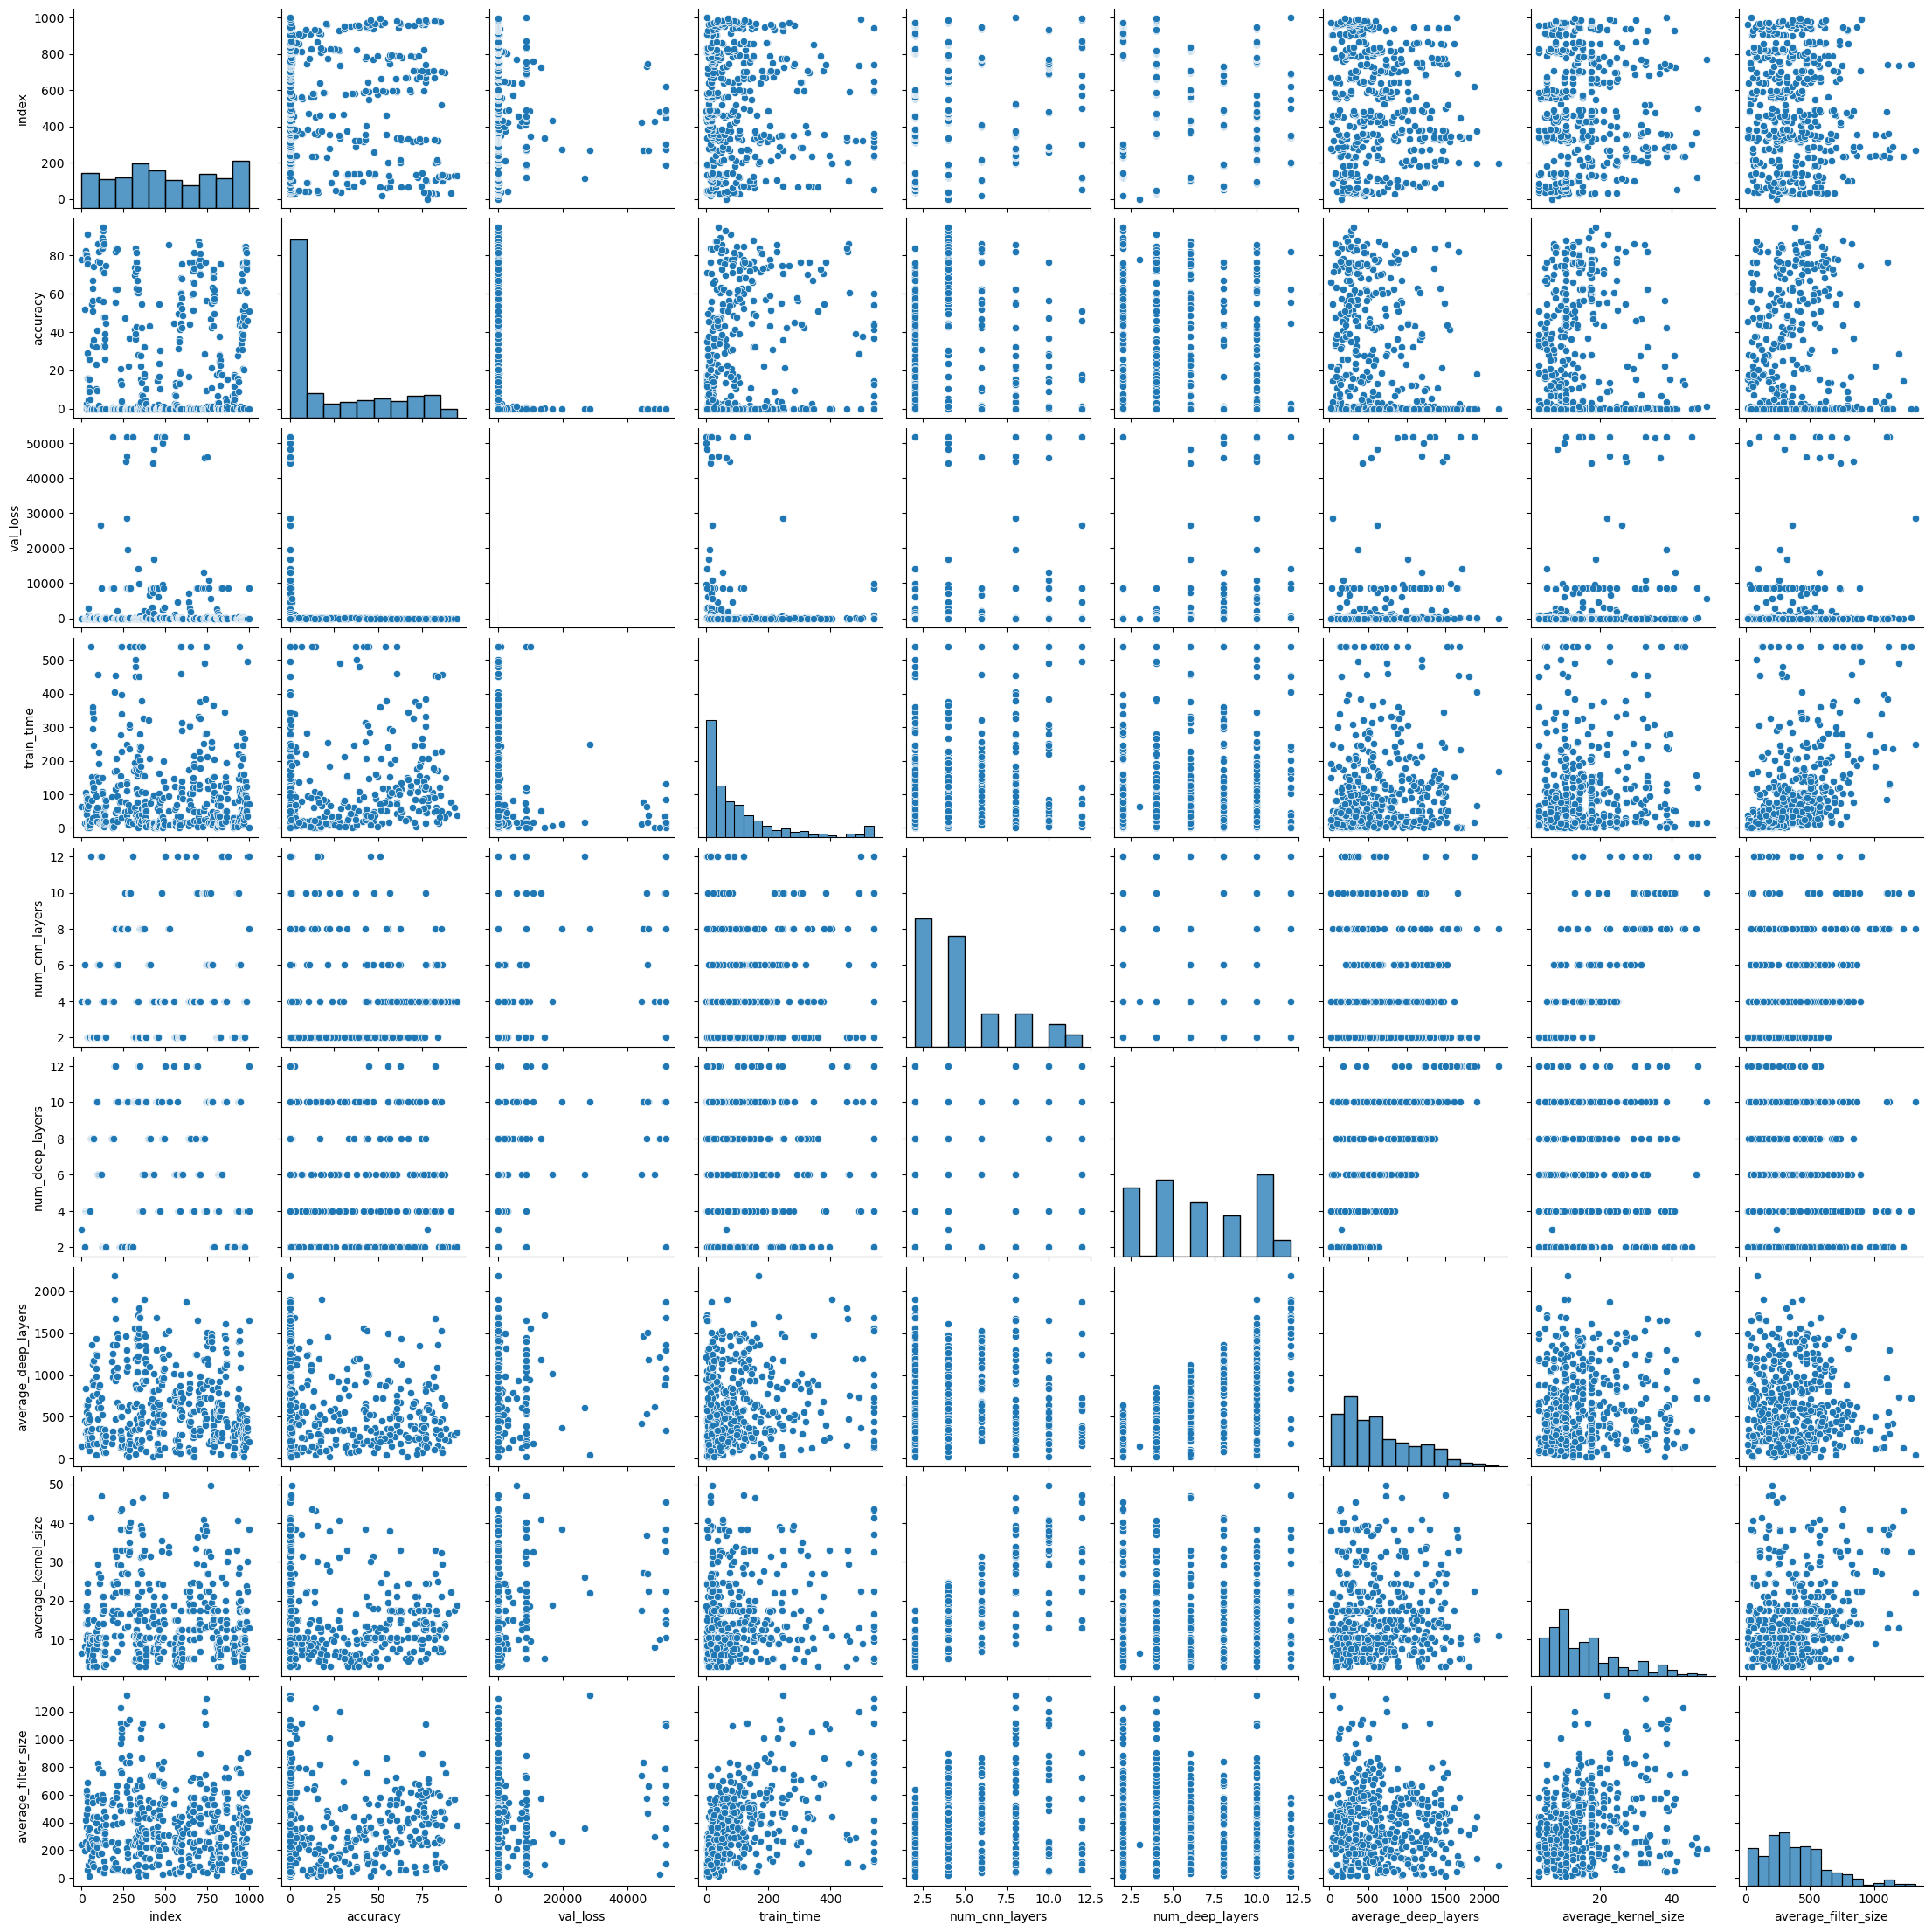

In [21]:
sns.pairplot(result_df_nonan)

In [12]:
result_df.columns

Index(['index', 'success', 'accuracy', 'median', 'val_loss', 'test_loss',
       'train_time', 'incomplete', 'num_cnn_layers', 'num_deep_layers',
       'initial_learning_rate', 'decay_rate', 'batch_size', 'deep_layer_size',
       'epochs', 'patience', 'input_shape', 'padding', 'dilation',
       'conv1d_filters', 'conv1d_kernel_size', 'batch_normalization',
       'dilation_rate_size', 'average_kernel_size', 'average_filter_size',
       'average_deep_layers'],
      dtype='object')

In [ ]:
result_df_fil = result_df[result_df['accuracy']>80]
plt.plot(result_df['accura'])

71.01724147796631


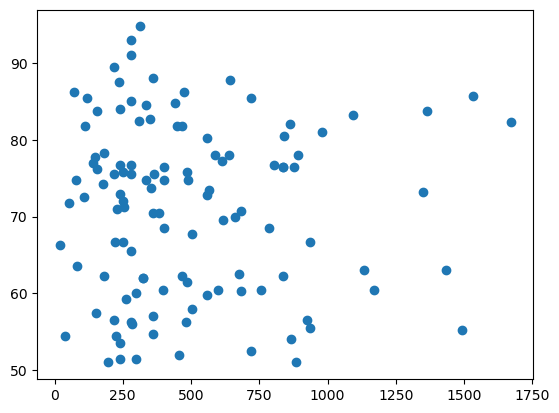

In [18]:
result_df_fil = result_df[result_df['accuracy']>50]
plt.scatter(result_df_fil['average_deep_layers'],result_df_fil['accuracy'])
print(result_df_fil['accuracy'].mean())

71.01724147796631


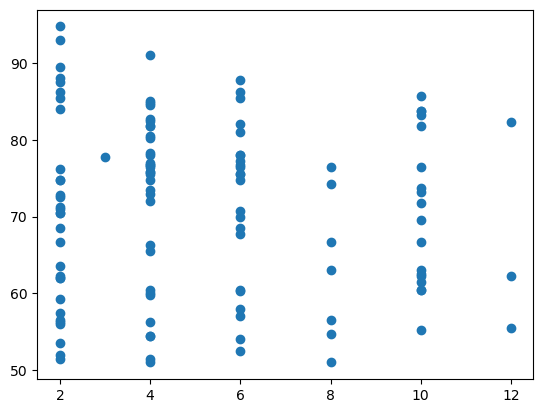

In [7]:
result_df_fil = result_df[result_df['accuracy']>50]
plt.scatter(result_df_fil['num_deep_layers'],result_df_fil['accuracy'])
print(result_df_fil['accuracy'].mean())

11.717703352704573


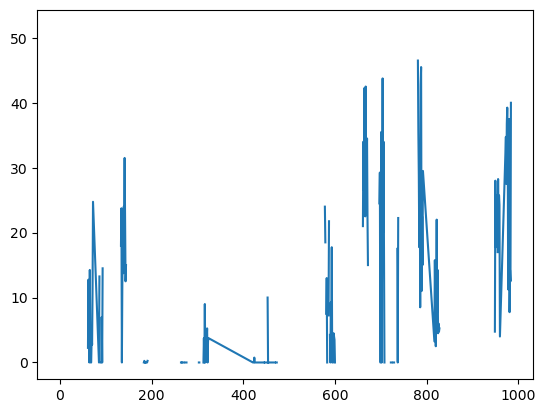

In [17]:
result_df_fil = result_df[result_df['batch_normalization'] == False]
plt.plot(result_df_fil['index'],result_df_fil['accuracy'])
print(np.mean(result_df_fil['accuracy']))

In [ ]:
sns.pairplot(result_df_nonan)

In [ ]:
np.argmax(result_df['train_time'])

In [ ]:
result_df.loc[319]

In [ ]:
result_df['train_time']

In [ ]:
result_df['val_loss'].min()

In [ ]:
result_df[result_df['train_time'] > 500]

In [ ]:
plt.scatter(result_df['train_time'],result_df['val_loss'])
plt.ylim(0,1000)

In [ ]:
result_df.loc[14]

In [ ]:
result_df[result_df['success']]

In [ ]:

if all_results:
    # Create a DataFrame to store the results
    results_df = pd.DataFrame(columns=['trial', 'val_loss', 'mse',
                                        'mae', 'accuracy', 'median',
                                        'num_deep_layers','average_deep_layers',
                                        'average_kernel_size','average_filter_size'])

    for result in all_results:
        results_df = results_df.append(result, ignore_index=True)

    results_df.to_csv(output_csv, index=False)

else:
    print("No results found.")

print('Indices that were not found are:', trials_not_found)


In [ ]:
results_df.iloc[results_df['val_loss'].idxmin()]

In [ ]:
import re

text = '''val_loss did not improve from 0.58202 
 val_loss did not improve from 0.58203'''

pattern = r"did not improve from (\d+\.\d+)"

match = re.findall(pattern, text)
if match:
    val_loss = match[-1]
    print("Val loss:", val_loss)

In [ ]:
match

# Script to combine results for the case of tuning of the diluted time based segmented data
import os
import json
import argparse
import csv
from pathlib import Path
from subprocess import check_output
import time
import pandas as pd
import glob
import re

'''
Combines all the hyperparameter results into a single csv file by gping through all the output log files.
'''

start_trial_index = 1
end_trial_index = 1000
output_csv = 'temp_hyperparameter.csv'
input_csv = 'meta_data/hyperparameters.csv'
hyperparameters_df = pd.read_csv('meta_data/hyperparameters.csv',delimiter=';')
dict_files = glob.glob('logs/results_trial_*.json')
out_files = glob.glob('logs/output.train.*')
error_files = glob.glob('logs/error.train.*')
all_results = []
pattern_trial = re.compile('trial: (\d+)')
pattern_job_id = re.compile('train.(\d+)')
trials_not_found = []
for i in range(len(out_files)):
    with open(out_files[i], 'r') as f:
        content = f.read()
    try: 
        trial_index = int(pattern_trial.findall(content)[0])
        job_id = int(pattern_job_id.findall(out_files[i])[0])

        error_log_file = Path(f'logs/error.train.{job_id}')
        result_file = Path(f'logs/results_trial_{trial_index}.json')
        row = hyperparameters_df.loc[hyperparameters_df['trial']==trial_index,
                                    ['trial','num_cnn_layers','num_deep_layers',
                                    'pool_size','num_param','memory','negative_value_error']]
        
        result_dict = row.to_dict('records')[0]
        result_dict['job_id'] = job_id
        
        if result_file.is_file():
            with open(result_file, 'r') as f:
                result_data = json.load(f)
                for key in ['val_loss','mse','mae','accuracy','median']:
                    result_dict[key] = float(result_data[key])
        else:
            result_dict['error'] = 'NotFound.'
        
        if error_log_file.is_file():
            with open(error_log_file, 'r') as f:
                error_log = f.read()
                if 'task 0: Exited with exit code 1' in error_log:
                    result_dict['error'] = 'OOM'

                elif 'task 0: Aborted' in error_log:
                    result_dict['error'] = 'Aborted'

        all_results.append(result_dict)
    except IndexError:
        trials_not_found.append(out_files[i])
        continue


if all_results:
    # Create a DataFrame to store the results
    results_df = pd.DataFrame(columns=['trial', 'val_loss', 'mse',
                                        'mae', 'accuracy', 'median',
                                        'num_param','memory','error',
                                        'num_cnn_layers','num_deep_layers',
                                        'pool_size','job_id','negative_value_error'])

    for result in all_results:
        results_df = results_df.append(result, ignore_index=True)

    results_df.to_csv(output_csv, index=False)

else:
    print("No results found.")

print('Indices that were not found are:', trials_not_found)



In [31]:
[round(i, 2) for i in np.arange(0.5, 0.8, 0.05)]

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]